In [1]:
import numpy as np 
import keras
import sklearn
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import h5py  
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences #pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical  #to convert an integer label into a vector 
import re #to use regular expression. Regular expressions are usually used for string matching
import warnings
warnings.filterwarnings('ignore')
import keras.callbacks
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Reading the train and test data

In [22]:
train_data = pd.read_csv('mitbih_train.csv')

In [23]:
test_data=pd.read_csv('mitbih_test.csv')

In [24]:
train_data=np.array(train_data)
np.shape(train_data)

(87553, 188)

In [25]:
test_data=np.array(test_data)

### Taking the labels and data seperately 

In [26]:
x_train=train_data[:,0:187]
y_train=train_data[:,187]

In [27]:
x_test=test_data[:,0:187]
y_test=test_data[:,187]

### Normalizing the data

In [28]:
scalar=Normalizer().fit(x_train)
x_train=scalar.transform(x_train)

In [29]:
scalar=Normalizer().fit(x_test)
x_test=scalar.transform(x_test)

### One hot encoding the labels

In [30]:
num_classes=5
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test1 = keras.utils.to_categorical(y_test, num_classes)

### Reshaping the train data into a tensor as keras takes only tensor input

In [31]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
input_shape=np.shape(x_train[0,:])

### Building a model 

In [32]:
model=Sequential()
model.add(Conv1D(64, kernel_size=3, border_mode="same",activation='relu', input_shape=(input_shape)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 187, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 93, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5952)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               761984    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 762,885
Trainable params: 762,885
Non-trainable params: 0
_________________________________________________________________


### Compiling themodel and saving each checkpoint weights.

In [33]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

checkpointer=keras.callbacks.ModelCheckpoint(filepath="F:/mlsp/ecg/Datas/chkp/checkpoint-{epoch:02d}.hdf5",verbose=1,save_best_only=True,monitor='loss')
csv_logger=CSVLogger("F:/mlsp/ecg/Datas/chkp/trainanalysis1.csv",separator=',',append=False)

model.fit(x_train, y_train,batch_size=100,epochs=1,verbose=1,callbacks=[checkpointer,csv_logger])
model.save('F:/mlsp/ecg/Datas/chkp/my_model.h5')  # creates a HDF5 file 'my_model.h5'


Epoch 1/1
87553/87553 [==============================] - 30s 346us/step - loss: 0.3739 - acc: 0.8936

Epoch 00001: loss improved from inf to 0.37386, saving model to F:/mlsp/ecg/Datas/chkp/checkpoint-01.hdf5


### Using desired checkpoint weights for evaluating the test data 

In [34]:

model.load_weights( "F:/mlsp/ecg/Datas/chkp/checkpoint-01.hdf5")


In [35]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
input_shape=np.shape(x_test[0,:])

In [36]:
prediction = model.predict_classes(x_test)
np.savetxt('chkp/expectd.txt',y_test,fmt='%01d')
np.savetxt('chkp/predicted.txt',prediction,fmt='%01d')
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
loss,accuracy=model.evaluate(x_test,y_test1)
print("\nLoss: %.2f,Accuracy: %.2f%%" % (loss,accuracy*100))

21891/21891 [==============================] - 2s 92us/step

Loss: 0.25,Accuracy: 92.65%


In [37]:
prediction.shape


(21891,)

In [38]:
y_test.shape

(21891,)

### Confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[18075     2    15     1    24]
 [  545     4     6     0     1]
 [  625     2   788    14    19]
 [  131     0    13    18     0]
 [  207     0     5     0  1396]]
Normalized confusion matrix
[[9.98e-01 1.10e-04 8.28e-04 5.52e-05 1.32e-03]
 [9.80e-01 7.19e-03 1.08e-02 0.00e+00 1.80e-03]
 [4.32e-01 1.38e-03 5.44e-01 9.67e-03 1.31e-02]
 [8.09e-01 0.00e+00 8.02e-02 1.11e-01 0.00e+00]
 [1.29e-01 0.00e+00 3.11e-03 0.00e+00 8.68e-01]]


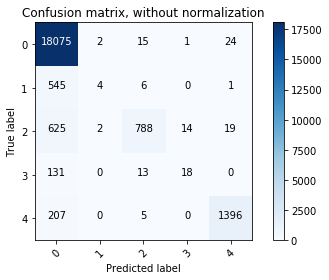

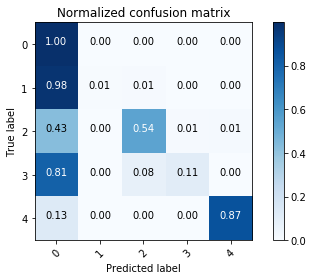

In [44]:
print(__doc__)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(y_test, prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Precision, Recall, F1 scores of each class

In [45]:
sklearn.metrics.precision_score(y_test, prediction, average=None)

array([0.92, 0.5 , 0.95, 0.55, 0.97])

In [46]:
sklearn.metrics.recall_score(y_test, prediction, average=None)

array([1.  , 0.01, 0.54, 0.11, 0.87])

In [47]:
sklearn.metrics.f1_score(y_test, prediction, average=None)

array([0.96, 0.01, 0.69, 0.18, 0.92])